In [734]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [735]:
initial_wealth = 25.0
p = 0.6                     # Probability of heads
n_flips = 1000              # Maximum number of flips
window = 50                 # Window size for MVO estimation
gamma = 2                   # Risk aversion coefficient
N_threshold_sims = 5000     # Simulations to estimate the percentile threshold

In [736]:
# Estimate the 90th percentile wealth threshold using Kelly strategy
mu = p * 1 + (1 - p) * (-1)
var = 1 - mu**2
f_true = 2 * p - 1
f_static = mu / (gamma * var)          

def simulate_kelly_run(n_flips, f):
    w = initial_wealth
    for _ in range(n_flips):
        outcome = 1 if np.random.rand() < p else -1
        bet = f * w
        w += bet * outcome
    return w

threshold_sims = np.array([simulate_kelly_run(n_flips, f_true) for _ in range(N_threshold_sims)])
threshold = np.quantile(threshold_sims, 0.90)
print(f"90th percentile wealth threshold: {threshold:.2f}")

90th percentile wealth threshold: 46185709025888.52


In [737]:
# Simulation function for each bot
def simulate_bot(strategy, n_flips, threshold):
    """
    Simulates a betting bot with one of four strategies:
    1. Kelly:          Perfect knowledge of true probability p.
    2. Rolling Kelly:  Estimates p from a rolling window of outcomes.
    3. Static MVO:     Perfect knowledge of true mean/variance.
    4. Rolling MVO:    Estimates mean/variance from a rolling window of outcomes.
    """
    w = initial_wealth
    history = [w]
    outcome_history = [] # Tracks the sequence of +1/-1 outcomes

    for t in range(n_flips):
        if w <= 0 or w >= threshold: 
            break
        
        # Determine the betting fraction f based on the chosen strategy
        if strategy == 'Kelly':
            f = f_true
        
        elif strategy == 'Static MVO':
            f = np.clip(f_static, 0.0, 1.0)
            
        # Rolling Kelly
        elif strategy == 'Rolling Kelly':
            if t < window:
                # Not enough history, use the true Kelly fraction as a starting point
                f = f_true
            else:
                # Get the outcomes from the rolling window
                window_outcomes = np.array(outcome_history[-window:])
                
                # Estimate the probability of winning from the window
                num_successes = (window_outcomes == 1).sum()
                num_trials = len(window_outcomes)
                
                p_est = num_successes / num_trials if num_trials > 0 else 0.5
                
                # Calculate the Kelly fraction based on the estimate
                f = 2 * p_est - 1
            
            # Clip the fraction: can't bet less than 0% or more than 100%
            f = np.clip(f, 0.0, 1.0)

        elif strategy == 'Rolling MVO':
            # Use default estimates if history is too short
            if t < window:
                mu_est, var_est = mu, var
            else:
                window_outcomes = np.array(outcome_history[-window:])
                
                if len(window_outcomes) < 2:
                    mu_est, var_est = 0.0, 1.0 
                else:
                    mu_est = window_outcomes.mean()
                    var_est = window_outcomes.var(ddof=1)
            
            # Calculate fraction f using MVO formula
            if var_est > 1e-6:
                f = mu_est / (gamma * var_est)
            else:
                f = 0.0
            
            f = np.clip(f, 0.0, 1.0)
        
        # Simulate the coin flip outcome
        outcome = 1 if np.random.rand() < p else -1
        w += f * w * outcome
        
        # Append results to history logs
        history.append(w)
        outcome_history.append(outcome)
    
    return np.array(history)

# Run simulations
hist_kelly          = simulate_bot('Kelly',          n_flips, threshold)
hist_static_mvo     = simulate_bot('Static MVO',     n_flips, threshold)
hist_rolling_mvo    = simulate_bot('Rolling MVO',    n_flips, threshold)
hist_rolling_kelly  = simulate_bot('Rolling Kelly',  n_flips, threshold)

# Compute summary statistics
def compute_stats(history):
    hist = np.array(history)
    prev = hist[:-1]
    diffs = np.diff(hist)
    mask = prev > 0
    if mask.sum() > 0:
        rets = diffs[mask] / prev[mask]
    else:
        rets = np.array([])
    cum_return = hist[-1] / hist[0] - 1
    std = rets.std(ddof=1) if rets.size > 1 else 0.0
    sharpe = rets.mean() / std if std > 0 else 0.0
    peaks = np.maximum.accumulate(hist)
    drawdowns = (peaks - hist) / peaks
    max_pct_dd = drawdowns.max()
    
    return pd.Series({
        'Final Wealth': hist[-1],
        'Cum. Return': cum_return,
        'Sharpe': sharpe,
        'Max % Drawdown': max_pct_dd
    })

stats = pd.DataFrame({
    'Kelly':          compute_stats(hist_kelly),
    'Static MVO':     compute_stats(hist_static_mvo),
    'Rolling MVO':    compute_stats(hist_rolling_mvo),
    'Rolling Kelly':  compute_stats(hist_rolling_kelly)
}).T
stats

,Final Wealth,Cum. Return,Sharpe,Max % Drawdown
Kelly,5.419414e+08,2.167766e+07,0.187103,0.984784
Static MVO,6.891327e+06,2.756521e+05,0.174515,0.691329
Rolling MVO,1.642138e+04,6.558552e+02,0.114928,0.879791
Rolling Kelly,2.895028e+07,1.158010e+06,0.183202,0.971298


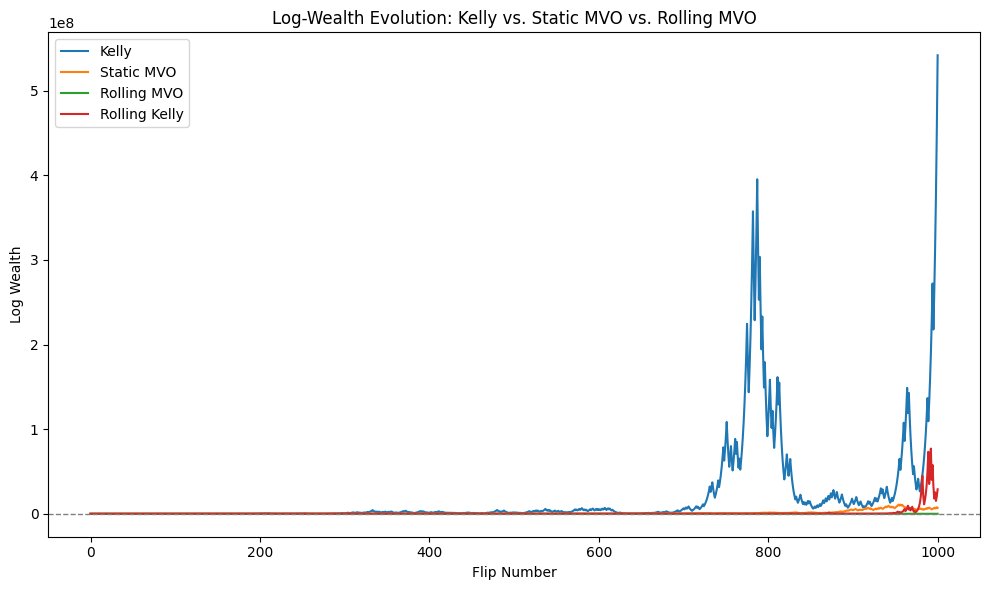

In [738]:
plt.figure(figsize=(10, 6))
plt.plot(hist_kelly,         label='Kelly')
plt.plot(hist_static_mvo,    label='Static MVO')
plt.plot(hist_rolling_mvo,   label='Rolling MVO')
plt.plot(hist_rolling_kelly, label='Rolling Kelly')
plt.axhline(np.log(initial_wealth), color='gray', linestyle='--', linewidth=1)
plt.xlabel('Flip Number')
plt.ylabel('Log Wealth')
plt.title('Log-Wealth Evolution: Kelly vs. Static MVO vs. Rolling MVO')
plt.legend()
plt.tight_layout()
plt.show()